In [28]:
# Import Modules

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [40]:
# read csv files
df = pd.read_csv('AEP_hourly.csv')
df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.Datetime = pd.to_datetime(df.Datetime)
df

,Datetime,AEP_MW
1970-01-01 00:00:00.000000000,2004-12-31 01:00:00,13478.0
1970-01-01 00:00:00.000000001,2004-12-31 02:00:00,12865.0
1970-01-01 00:00:00.000000002,2004-12-31 03:00:00,12577.0
1970-01-01 00:00:00.000000003,2004-12-31 04:00:00,12517.0
1970-01-01 00:00:00.000000004,2004-12-31 05:00:00,12670.0
...,...,...
1970-01-01 00:00:00.000121268,2018-01-01 20:00:00,21089.0
1970-01-01 00:00:00.000121269,2018-01-01 21:00:00,20999.0
1970-01-01 00:00:00.000121270,2018-01-01 22:00:00,20820.0
1970-01-01 00:00:00.000121271,2018-01-01 23:00:00,20415.0


In [14]:
print('Min: {}\nMax: {}'.format(df.Datetime.min(), df.Datetime.max()))

Min: 2004-10-01 01:00:00
Max: 2018-08-03 00:00:00


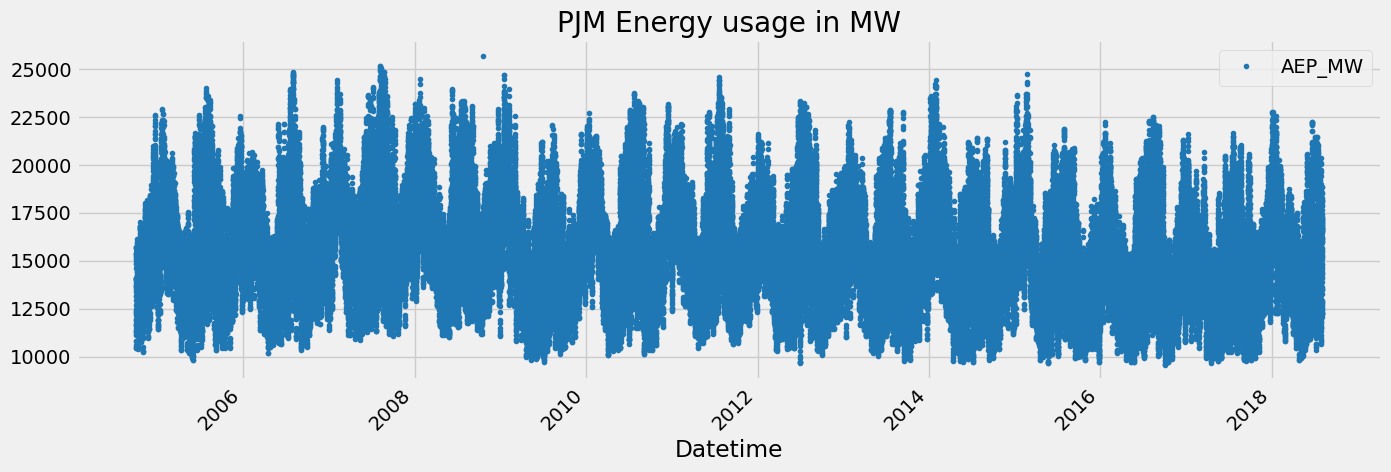

In [17]:
# Plot data
df.plot(x = 'Datetime', y = 'AEP_MW', style='.', figsize=(15,5), color = color_pal[0], title='AEP Energy usage in MW', rot=45)
plt.show()

In [18]:
# split train and test
train = df.loc[df.Datetime < '2015-01-01']
test = df.loc[df.Datetime >= '2015-01-01']

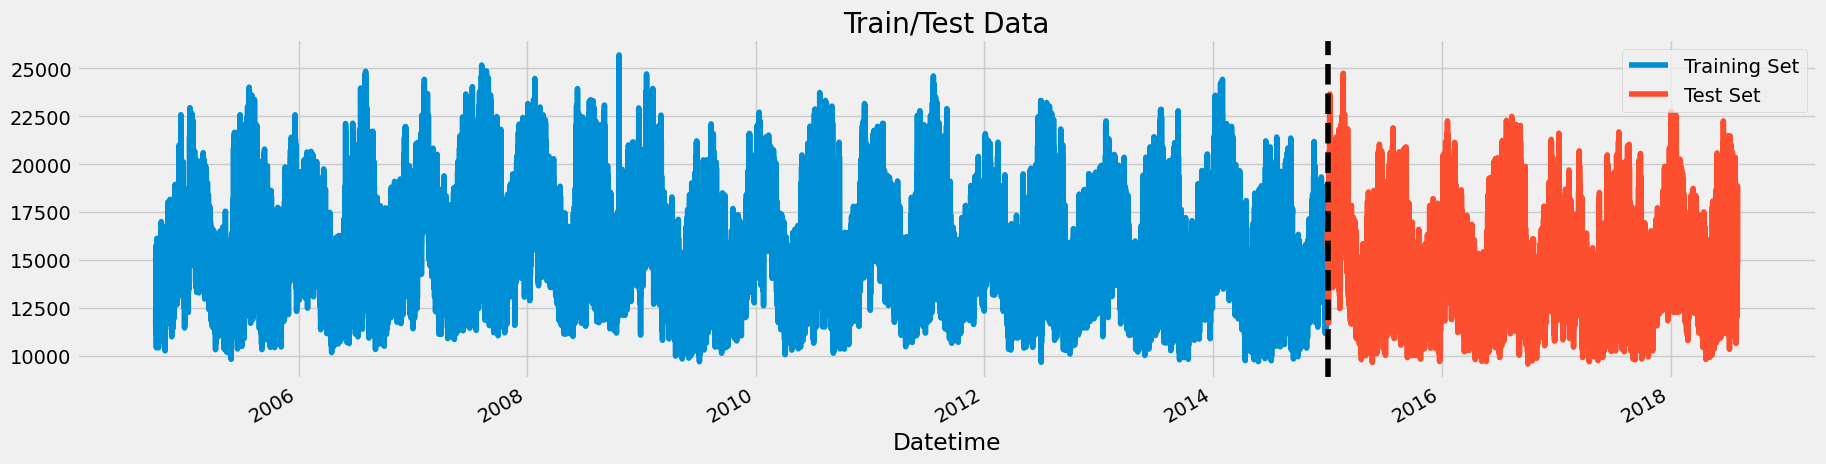

In [42]:
# plot train and test data
fig, ax = plt.subplots(figsize=(20,5))
train.plot(x = 'Datetime', y = 'AEP_MW', ax=ax, label='Training Set', title='Train/Test Data')
test.plot(x = 'Datetime', y = 'AEP_MW', ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

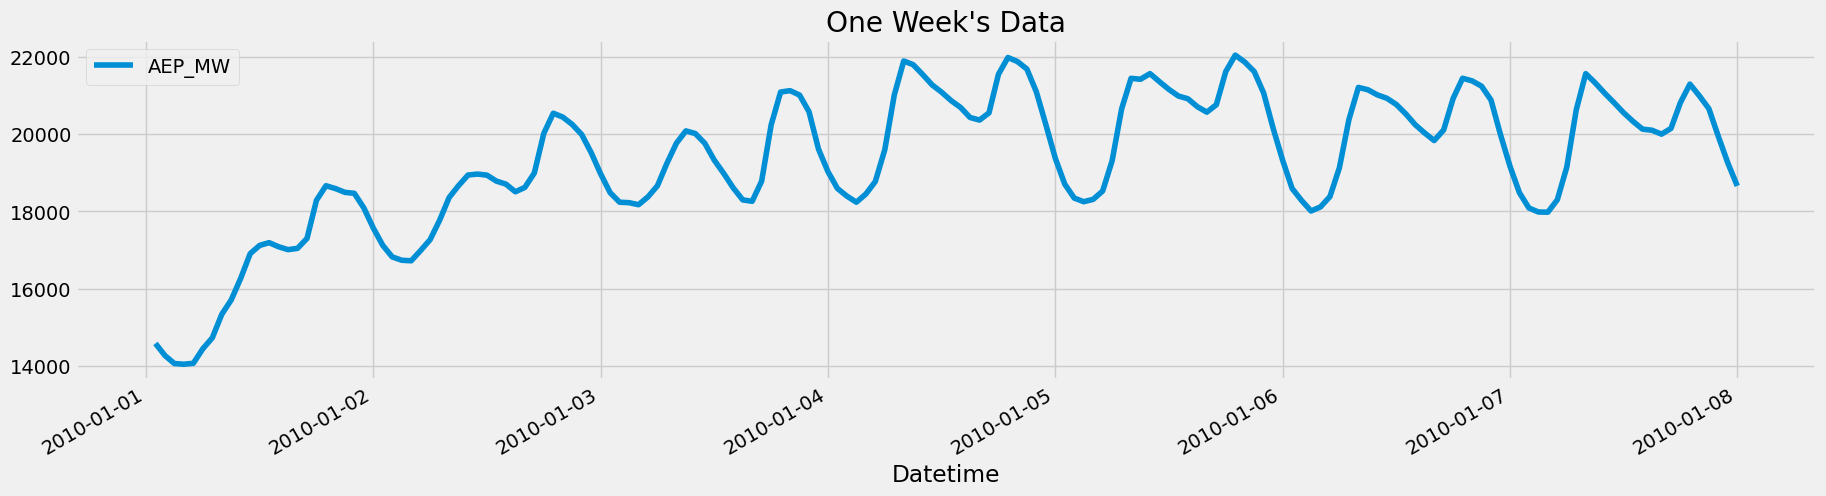

In [22]:
df.loc[(df.Datetime > '2010-01-01') & (df.Datetime <= '2010-01-08')].plot(x = 'Datetime', y = 'AEP_MW', figsize=(20,5), title="One Week's Data")
plt.show()

In [24]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.Datetime.dt.hour
    df['dayofweek'] = df.Datetime.dt.dayofweek
    df['quarter'] = df.Datetime.dt.quarter
    df['month'] = df.Datetime.dt.month
    df['year'] = df.Datetime.dt.year
    df['dayofyear'] = df.Datetime.dt.dayofyear
    df['dayofmonth'] = df.Datetime.dt.day
    df['weekofyear'] = df.Datetime.dt.isocalendar().week
    return df

df = create_features(df)
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = ['AEP_MW']

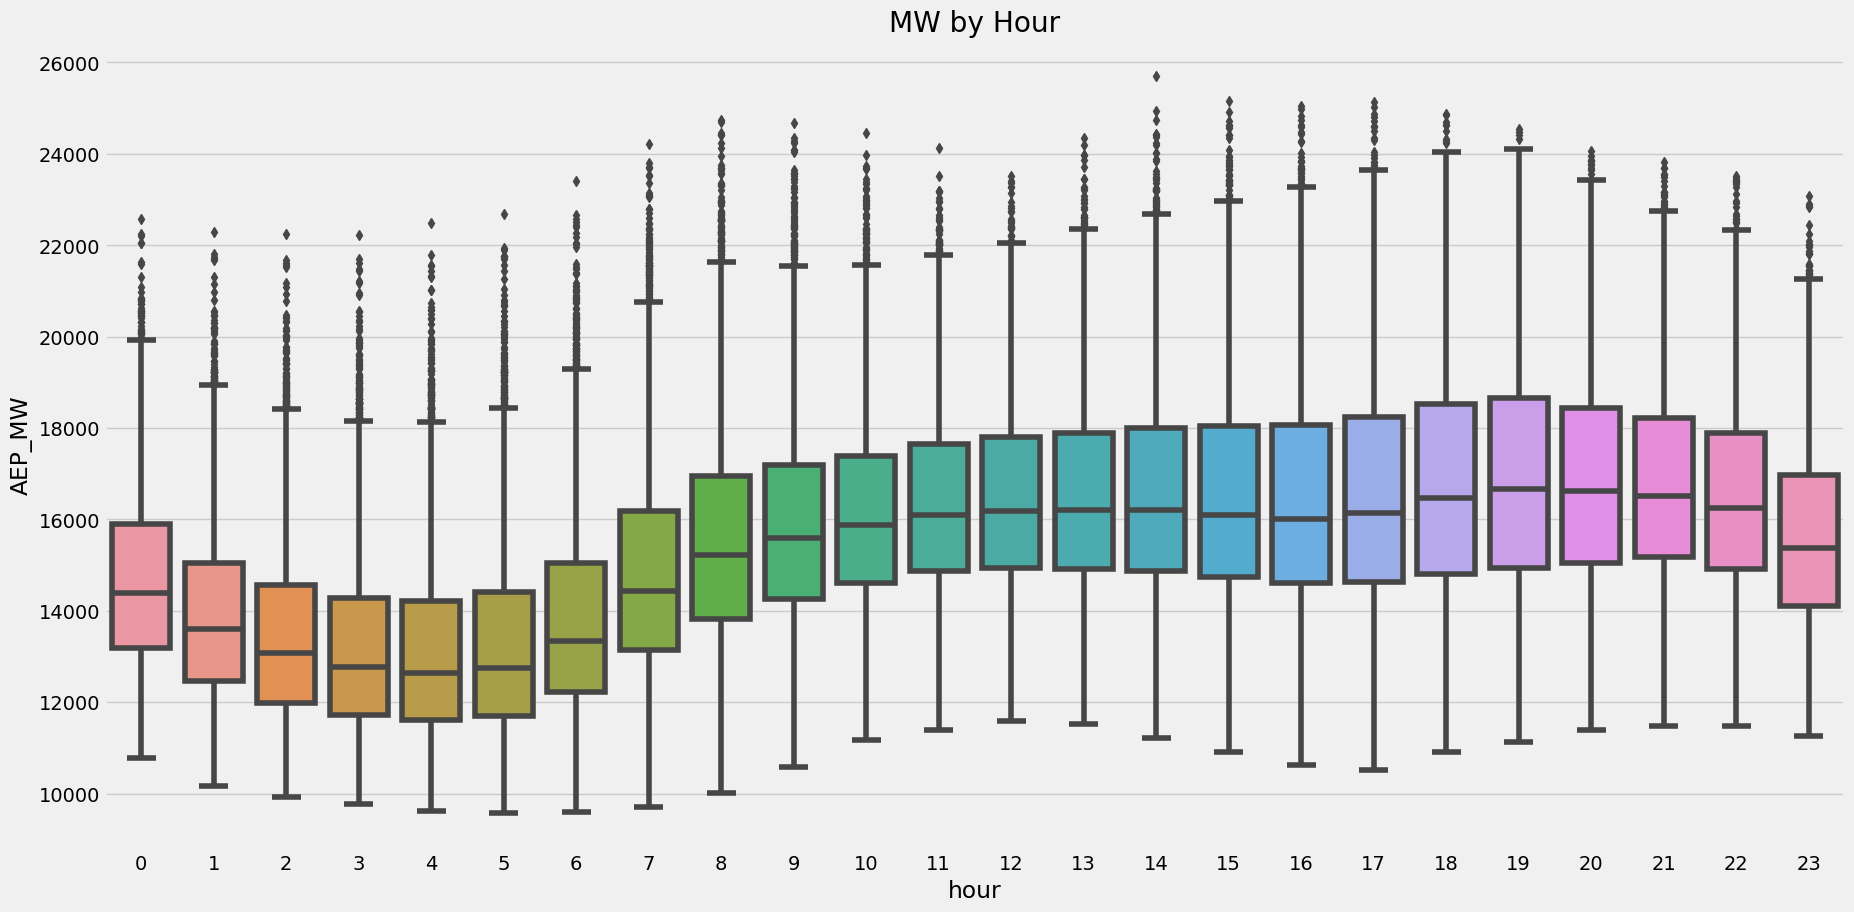

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

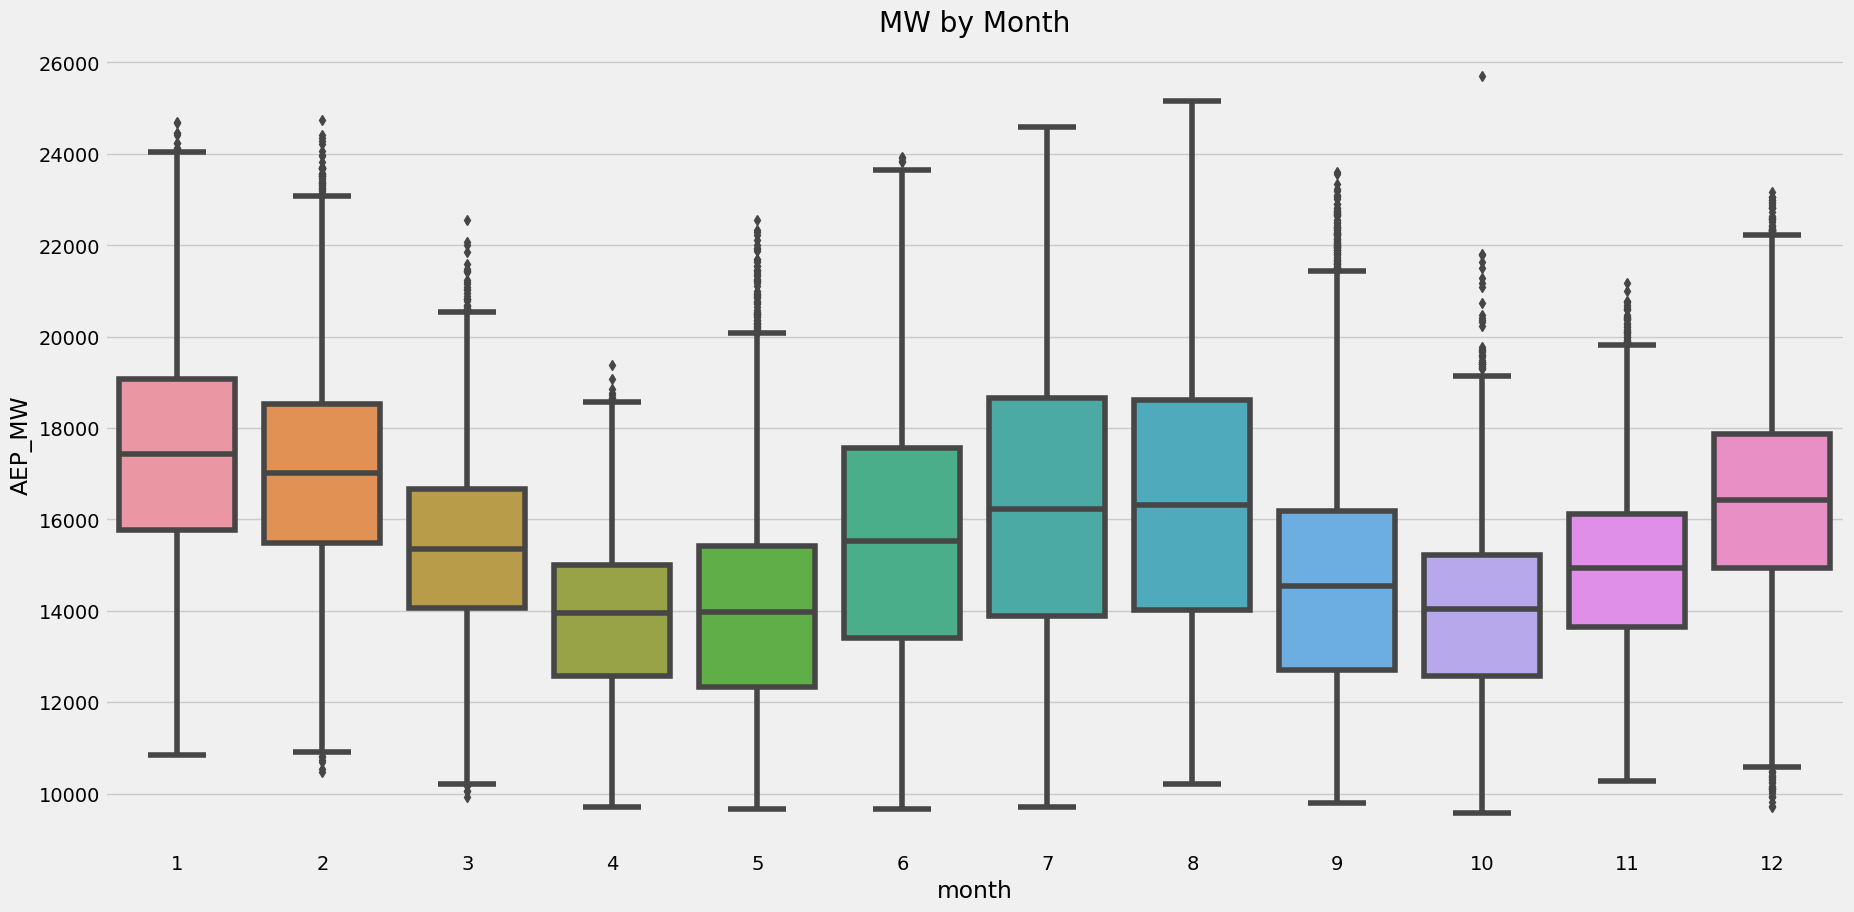

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

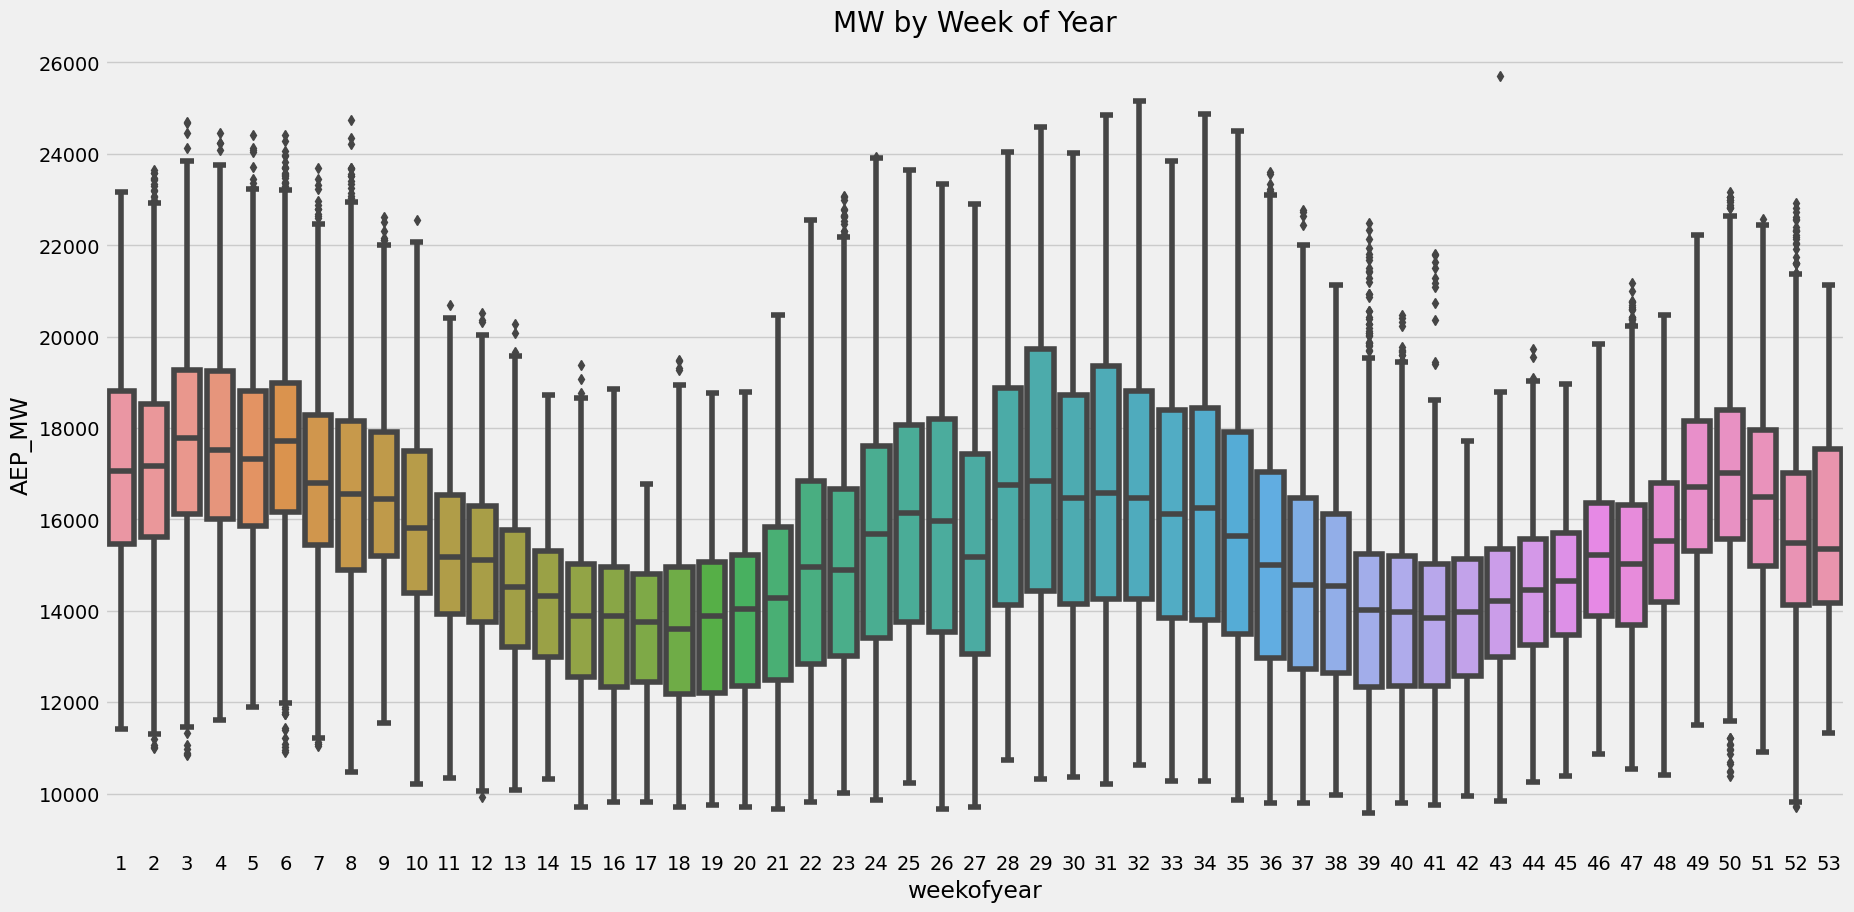

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='weekofyear', y='AEP_MW')
ax.set_title('MW by Week of Year')
plt.show()

In [30]:
#creating model
train = create_features(train)
test = create_features(test)

In [31]:
x_train = train[features]
x_test = test[features]

y_train = train[target]
y_test = test[target]

In [32]:
reg = xgb.XGBRegressor(n_estimators=1000, booster='gbtree', base_score=0.5, early_stopping_rounds=50, objective='reg:linear', max_depth=5, learning_rate=0.01)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

[09:44:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15792.80344	validation_1-rmse:14860.82206
[100]	validation_0-rmse:5972.52076	validation_1-rmse:5172.34960
[200]	validation_0-rmse:2555.50160	validation_1-rmse:2121.86237
[300]	validation_0-rmse:1547.14452	validation_1-rmse:1583.53923
[390]	validation_0-rmse:1296.12284	validation_1-rmse:1577.13279


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

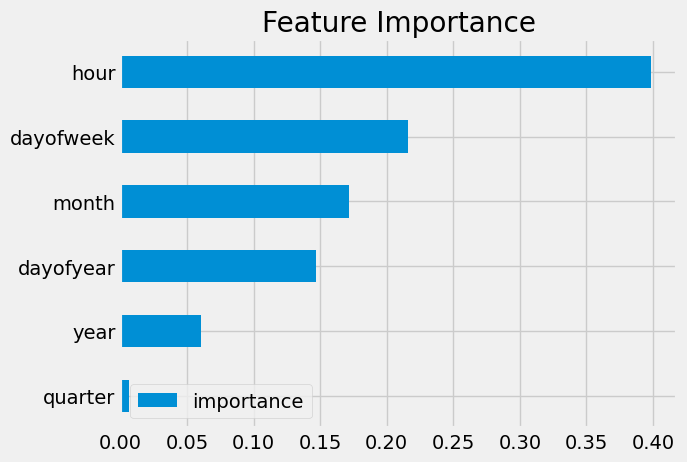

In [33]:
fi = pd.DataFrame(data=reg.feature_importances_, index = reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

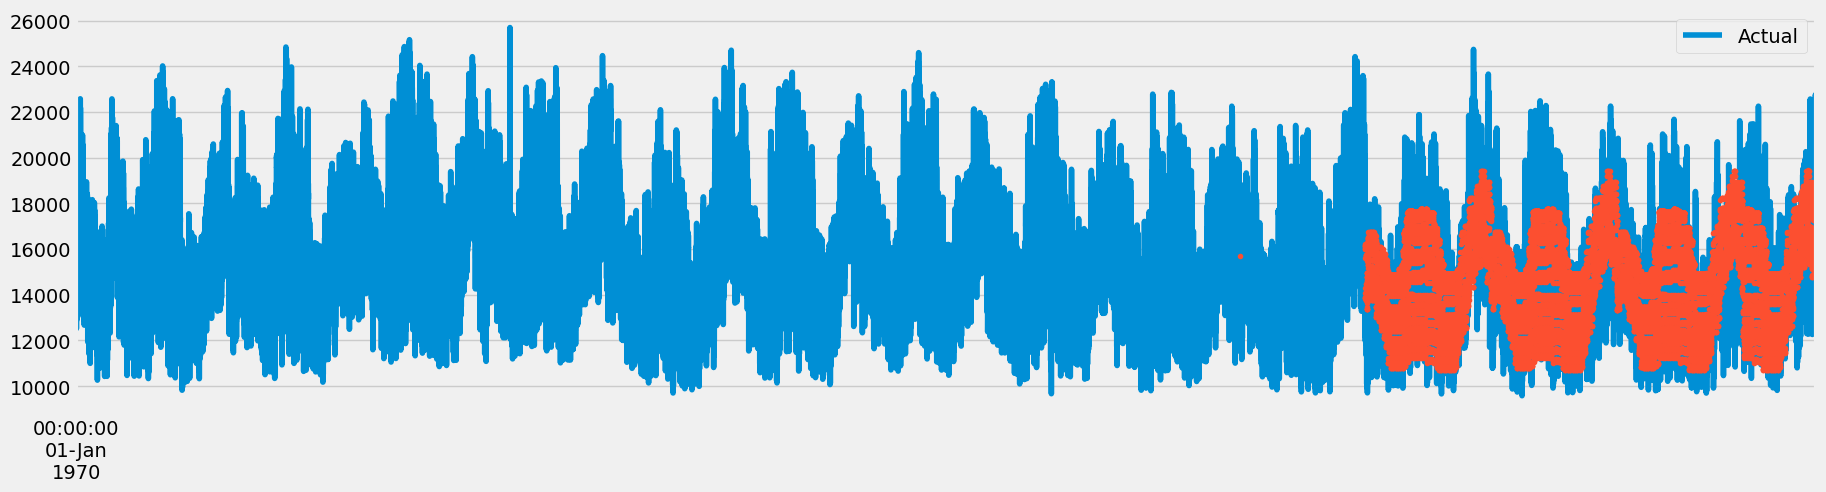

In [36]:
#prediction`
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df['AEP_MW'].plot(figsize=(20, 5))
plt.legend(['Actual', 'Predicted'])
df['prediction'].plot(style='.')
plt.show()

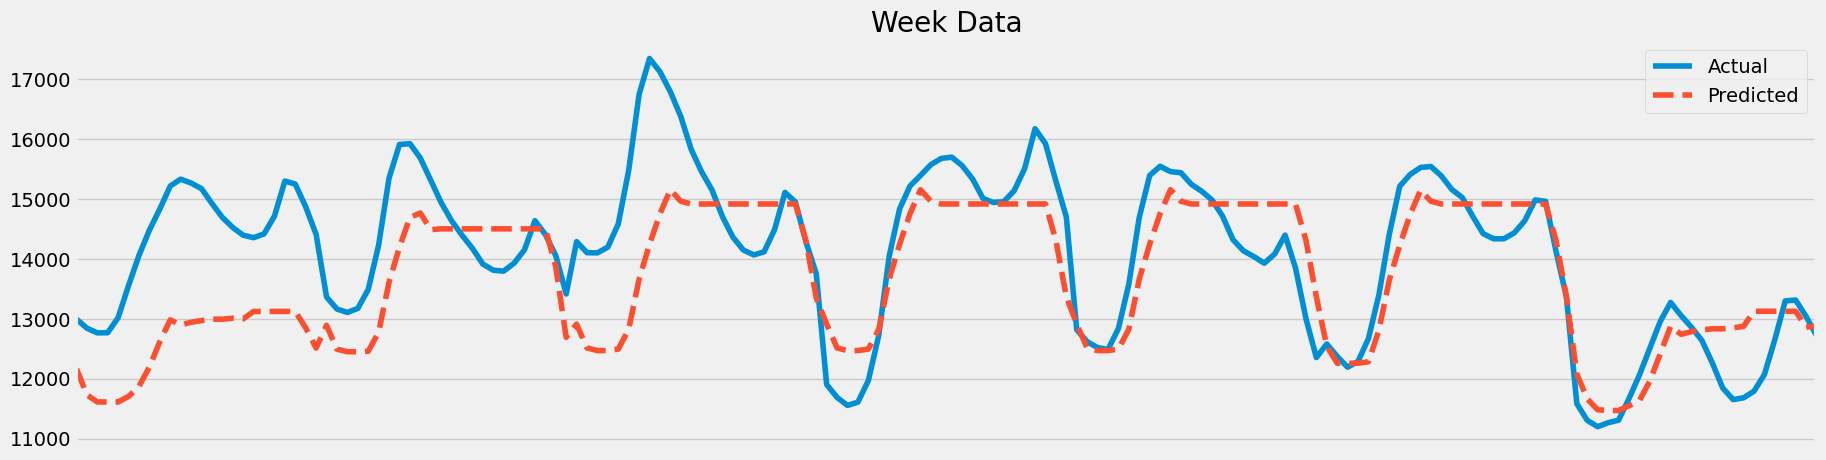

In [39]:
ax = df.loc[(df.Datetime > '2018-04-01') & (df.Datetime <= '2018-04-08')]['AEP_MW'].plot(figsize=(20,5), title='Week Data')
df.loc[(df.Datetime > '2018-04-01') & (df.Datetime <= '2018-04-08')]['prediction'].plot(style='--')
plt.legend(['Actual', 'Predicted'])
plt.show()